In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Data

In [ ]:
# Load dataset with only the ToTensor transform to compute mean and std
compute_transform = transforms.Compose([transforms.ToTensor()])
dataset = torchvision.datasets.FashionMNIST(root = "data", train=True, download=True, transform=compute_transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=1024, num_workers=2, shuffle=True)

mean = 0.0
for images, _ in loader:
  batch_samples = images.size(0)  # Batch size
  images = images.view(batch_samples, images.size(1), -1)
  mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

variance = 0.0
for images, _ in loader:
  batch_samples = images.size(0)
  images = images.view(batch_samples, images.size(1), -1)
  variance += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(variance / (len(loader.dataset)*28*28))

print(mean, std)

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.86MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 163kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.03MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.08MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



tensor([0.2860]) tensor([0.3530])


In [ ]:
# Compute mean and std in advance
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean, ), (std, ))])

trainset = torchvision.datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=2, shuffle=True)

testset = torchvision.datasets.FashionMNIST(root="data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=2, shuffle=False)

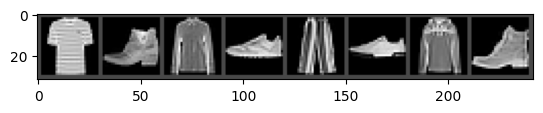

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the image
def imshow(img):
  img = img*std + mean
  np_img = img.numpy()
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
  # Plot some images
  imshow(torchvision.utils.make_grid(images[:8]))
  break

### Model

In [ ]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)
model = model.to(device)

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)


In [ ]:
# Generating a random tensor
input_tensor = torch.rand(5, 28, 28).to(device)

# Feeding the tensor into the model
output = model(input_tensor)
print(output.shape)

torch.Size([5, 10])


### Loss, Optimizer, and Evaluation Function

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
  model.eval()
  test_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
    for images, labels in testloader:
      # Move inputs and labels to the device
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)
      test_loss += loss

      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  accuracy = 100 * correct / total
  test_loss = test_loss / len(testloader)
  return test_loss, accuracy

In [ ]:
test_loss, test_accuracy = evaluate(model, testloader, criterion)
print(f'test_loss: {test_loss}')
print(f'test accuracy: {test_accuracy}')

test_loss: 2.3588876724243164
test accuracy: 8.84


### Train

In [ ]:
# some parameters
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 100

In [ ]:
# Train
for epoch in range(max_epoch):
  running_loss = 0.0
  running_correct = 0
  total = 0

  for i, (inputs, labels) in enumerate(trainloader, 0):
    # Move inputs and labels to the device
    inputs, labels = inputs.to(device), labels.to(device)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss

    # Determine class prediction and track accuracy
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    running_correct += (predicted == labels).sum().item()

    # Backward and optimization
    loss.backward()
    optimizer.step()

  epoch_accuracy = 100 * running_correct / total
  epoch_loss = running_loss / (i+1)
  test_loss, test_accuracy = evaluate(model, testloader, criterion)
  print(f"Epoch [{epoch + 1}/{max_epoch}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%]")

  # Save for plot
  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy)
  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

Epoch [1/100, Loss: 1.6595, Accuracy: 55.89%, Test Loss: 1.1992, Test Accuracy: 69.18%]
Epoch [2/100, Loss: 1.0164, Accuracy: 71.63%, Test Loss: 0.9032, Test Accuracy: 72.58%]
Epoch [3/100, Loss: 0.8282, Accuracy: 74.14%, Test Loss: 0.7867, Test Accuracy: 74.13%]
Epoch [4/100, Loss: 0.7396, Accuracy: 75.78%, Test Loss: 0.7223, Test Accuracy: 75.62%]
Epoch [5/100, Loss: 0.6860, Accuracy: 76.98%, Test Loss: 0.6804, Test Accuracy: 76.68%]
Epoch [6/100, Loss: 0.6491, Accuracy: 77.92%, Test Loss: 0.6502, Test Accuracy: 77.39%]
Epoch [7/100, Loss: 0.6214, Accuracy: 78.69%, Test Loss: 0.6275, Test Accuracy: 78.04%]
Epoch [8/100, Loss: 0.5995, Accuracy: 79.33%, Test Loss: 0.6088, Test Accuracy: 78.58%]
Epoch [9/100, Loss: 0.5825, Accuracy: 79.82%, Test Loss: 0.5939, Test Accuracy: 79.08%]
Epoch [10/100, Loss: 0.5670, Accuracy: 80.29%, Test Loss: 0.5808, Test Accuracy: 79.52%]
Epoch [11/100, Loss: 0.5541, Accuracy: 80.66%, Test Loss: 0.5694, Test Accuracy: 79.92%]
Epoch [12/100, Loss: 0.5431, A

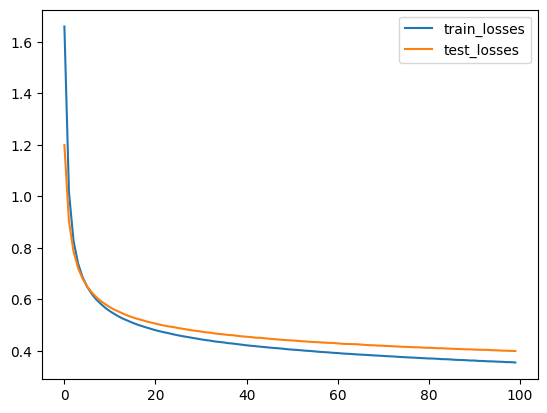

In [ ]:
import matplotlib.pyplot as plt

train_losses_cpu = [loss.cpu().detach().numpy() for loss in train_losses]
test_losses_cpu = [loss.cpu().detach().numpy() for loss in test_losses]

plt.plot(train_losses_cpu, label='train_losses')  # Plot using the NumPy arrays
plt.plot(test_losses_cpu, label='test_losses')
plt.legend()
plt.show()

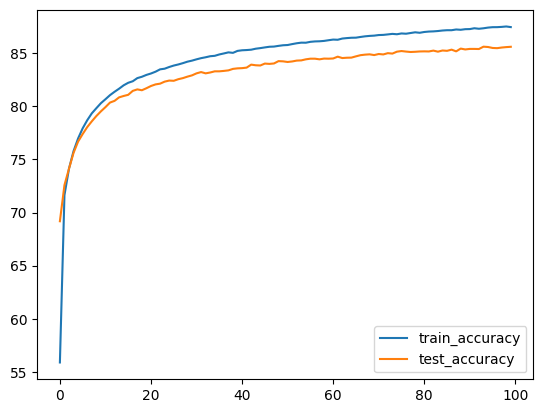

In [ ]:
import matplotlib.pyplot as plt


plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()